<a href="https://colab.research.google.com/github/turtler12/CV_Homework/blob/main/pset6_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 6: 3D Projective Geometry and Structured Light

This assignment is entirely contained within this Jupyter notebook, which you can host on Google Colab. If you're more comfortable with your local dev environment, feel free to download this notebook instead ("File -> Download -> Download .ipynb") and edit it in your local environment. Otherwise log into your Google Account and click "File -> Save a copy in Drive". You can then edit your copy of the notebook to complete your assignment. You'll find instructions for submitting your work at the [end of this notebook](#scrollTo=Submission_Instructions).

Your grade on this problem set will be determined by an autograder that runs your code against a set of hidden test cases. Read section 0.3 for details.

# 0. Setup
The next couple of cells import/download the required packages and setup some common methods that you will need for the rest of this problem set.

## 0.1. Imports

In [ ]:
# Install openmesh
!pip install openmesh

# Visualization libraries
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import torch

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple, Any, Iterable

# We'll use a namedtuple to store scene information in an accessible way
from collections import namedtuple

# For reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openmesh: filename=openmesh-1.2.1-cp311-cp311-linux_x86_64.whl size=855153 sha256=daedd088762aa4f4e91fcc3cb1a1dc6af963af6a077d4554c8c80dad17c95455
  Stored in directory: /root/.cache/pip/wheels/0b/a7/38/804273ff91448699d5ba1d1c640e6321efa76c659d1ddf4ca9
Successfully built openmesh


## 0.2. Utilities

In [ ]:
# This pset does not require a CUDA device. It can be done using only a CPU
#
device = torch.device("cpu")

# We'll create a simple namedtuple to hold information about our scene for
# Problem 2 (Structured Light)
#
Scene = namedtuple('Scene',
                   ['rgb_ground_truth',
                    'z_proj_ground_truth',
                    'z_cam_ground_truth',
                    'cam_extrinsics',
                    'cam_intrinsics',
                    'proj_extrinsics',
                    'proj_intrinsics'])

In [ ]:
# Setup display utilities
def imshow(img, ax=plt, cmap=None):
    if len(img.shape) == 3:
        # display color image
        img_RGB = img[:,:,::-1] # convert BGR to RGB
        img_RGB[np.isnan(img_RGB)] = img_RGB[~np.isnan(img_RGB)].min() # visualize nan as the minimal color
        axis_image = ax.imshow(img_RGB, cmap=cmap)
    else:
        # display depth image
        img_depth = img.copy()
        img_depth[np.isnan(img_depth)] = img_depth[~np.isnan(img_depth)].min() # visualize nan as the minimal depth
        axis_image = ax.imshow(img_depth, cmap=cmap)

    return axis_image

# Animation wrapper to make it easy to display a series of frames in colab
class AnimationWrapper():
    def __init__(self, rows, cols, frames, figsize=(8, 6)):
        self.rows, self.cols = rows, cols
        self.frames = frames

        self.fig = plt.figure(figsize=figsize)
        self.axes = []
        self.axis_images = []
        self.data = []
        self.pbar = None
        for r in range(rows):
            for c in range(cols):
                ax = plt.subplot(rows, cols, r * cols + c + 1)
                img = imshow(frames[0][r * cols + c], ax=ax)

                self.axes.append(ax)
                self.axis_images.append(img)
                self.data.append([])
        plt.close()

        # Set maximal limit to 100 MB, default is 20 MB
        matplotlib.rcParams['animation.embed_limit'] = 100

    def get_axes(self):
        return self.axes

    def animate(self, i):
        self.pbar.update(1)

        for ax_id in range(len(self.axis_images)):
            frame = self.frames[i][ax_id]
            if len(frame.shape) == 3:
                self.axis_images[ax_id].set_data(frame[:,:,::-1])
            else:
                depth = frame.copy()
                depth[np.isnan(depth)] = depth[~np.isnan(depth)].min()
                self.axis_images[ax_id].set_data(depth)
                self.axis_images[ax_id].set_clim(depth.min(), depth.max())
        return tuple(self.axis_images)

    def generate(self):
        self.pbar = tqdm.tqdm(total = len(self.frames), position=0, leave=True, desc="Building animation... ")
        self.anim = animation.FuncAnimation(self.fig, self.animate, frames=len(self.frames), interval=100, blit=True)

        # Note: below is the part which makes it work on Colab
        rc('animation', html='jshtml')

## 0.3. Testing your code and grading

For your convenience, we have written a helper function for you to write and run test cases for the functions you have to write. We will test your code against hidden test cases. For example, if the function signature specifies inputs of size (N,d), you should ensure that your code works for multiple values of N and d.

Your code does not need to handle edge cases or improper inputs, and it does not need to run efficiently. Our autograder does not give partial credit for beautiful, well-documented code if it is wrong. If you change any of the function names, the autograder will fail and your score will be 0.

In [ ]:
def check_function(function: Callable, test_inputs: list, expected_outputs: list):
    """Checks that the output of a function with given inputs is close to the expected output value."""
    actual_outputs = function(*test_inputs)
    if isinstance(actual_outputs, tuple):
        actual_outputs = list(actual_outputs)
    else:
        actual_outputs = [actual_outputs]

    for i in range(len(expected_outputs)):
        assert torch.allclose(actual_outputs[i], expected_outputs[i], rtol=1e-03, atol=1e-05), f"Output mismatch\n\n  Expected:\n{expected_outputs[i]}\n\n  Actual Output:\n{actual_outputs[i]}"

# 1. Coordinate Transforms & Projective Geometry
We'll start with writing some simple transformations on points in 3D space, learn how to project them to 2D image space and apply them to render a simple point cloud.

## 1.1. Rigid transformations

A rigid-body transform of a 3D point consists of a rotation and a translation. Such transforms are necessary whenever converting between camera coordinates and 3D world coordinates.

Given a point $\mathbf{v} \in \mathbb{R}^3$ that we want to transform, a rigid-body transform is formally defined as:
$$
\mathbf{v}' = \mathbf{R} \mathbf{v} + \mathbf{t},
$$
with a rotation matrix $\mathbf{R} \in SO(3)$, and a translation $\mathbf{t} \in \mathbb{R}^3$.

Consider appending a fourth dimension to $\mathbf{v}$ with value 1. Then instead of breaking up a rigid body transformation transformation into a matrix-vector product and a sum, we may instead write it as a single matrix-vector product:
$$
\mathbf{v}' = \mathbf{T} \mathbf{v},
$$
where
$$
    \mathbf{T} = \begin{bmatrix}
                    \mathbf{R} & \mathbf{t} \\
                    \mathbf{0} & 1
                 \end{bmatrix}
$$

When $\mathbf{v}$ has this 4D form, it is called **homogeneous coordinates** (see textbook [38.2](https://visionbook.mit.edu/homogeneous_coordinates.html#homogeneous-and-heteregenous-coordinates)). Using homogeneous coordinates is convenient as it allows us to compose multiple coordinate transformations by performing matrix products. As well, we can revert transformations by simply inverting the matrix $\mathbf{T}$, i.e.:
$$
    \mathbf{v} = \mathbf{T}^{-1} \mathbf{v}.
$$

Note that appending 1 to $\mathbf{v}$ has the effect of adding $\mathbf{t}$ to the result of the rotation. There are times when we also want to express directional vectors in $\mathbb{R}^3$ (e.g. normal vectors on a surface) using homogeneous coordinates. Because directional vectors are affected by rotation but not by translation, we append a 0 to such vectors.

Homogeneous coordinates can also be used to express 2D rotations and translations, in which case a third dimension is appended.

Below, implement three functions: one to homogenize points, one to homogenize directional vectors, and one to apply a rigid-body transform to homogenized points or directions.

In [ ]:
# @title 0.5 points
def homogenize_points(points: torch.Tensor) -> torch.Tensor:
    """
    Args:
        points: points of shape (N, d)

    Returns:
        vectors of shape (N, d+1)
    """
    N, _ = points.shape
    ones = torch.ones(N, 1, dtype=points.dtype, device=points.device)
    return torch.cat([points, ones], dim=1)

# Example test case: homogenize_points([[0, 0, 0]]) should map to [[0, 0, 0, 1]]
check_function(homogenize_points,
               [torch.zeros(1, 3)],
               [torch.tensor([[0., 0., 0., 1.]])])

In [ ]:
# @title 0.5 points
def homogenize_dirs(directions: torch.Tensor) -> torch.Tensor:
    """
    Args:
        directions: directional vectors of shape (N, d)

    Returns:
        vectors of shape (N, d+1)
    """
    N, _ = directions.shape
    zeros = torch.zeros(N, 1, dtype=directions.dtype, device=directions.device)
    return torch.cat([directions, zeros], dim=1)

check_function(homogenize_dirs,
               [torch.zeros(1, 3)],
               [torch.zeros(1, 4)])

In [ ]:
# @title 1 point
def transform_rigid(xyz_hom: torch.Tensor, T: torch.Tensor) -> torch.Tensor:
    """Apply a rigid-body transform to a batch of points / directions.

    Args:
        xyz_hom: homogeneous 3D vectors of shape (N,4)
        T: rigid-body transform matrix of shape (4,4)

    Returns:
        transformed vectors in homogeneous coordinates
    """
    return xyz_hom @ T.T

check_function(transform_rigid,
               [torch.tensor([[0., 0, 0, 1]]),
                torch.tensor([[0, 0, 0, 1.],
                              [0, 0, 0, 0],
                              [0, 0, 0, 0],
                              [0, 0, 0, 1]])],
               [torch.tensor([[1., 0, 0, 1.]])])

## 1.2. Camera parameters and transforms

To relate the image captured by a camera to 3D points in a scene, we model a pinhole camera via two parameters: the extrinsic camera matrix (aka camera pose) and the intrinsic camera matrix.



### 1.2. (a) Camera Extrinsics (see Textbook [39.4](https://visionbook.mit.edu/imaging_geometry.html#camera-extrinsic-parameters) and Lecture 17 slides 54-60)

The extrinsic camera matrix (pose) is the rigid transformation that defines the position and rotation of a camera relative to some canonical frame of reference that is referred to as **world coordinates**. By convention, we store the ```cam2world``` format, i.e., a matrix that acts on camera coordinates to produce world coordinates. Naturally, the ```world2cam``` transform is its inverse.

For the rest of the course, we adopt the **OpenCV conventions** for camera coordinates. That means:

*   Image origin $(0, 0)$ is at top left corner
*   y-axis points down
*   x-axis points right
*   z-axis points into the image plane, i.e., things further in front of the camera have larger z values.

Next, we will write convenience functions to transform points and vectors from camera to world coordinates and vice-versa.

Below, **implement the functions `transform_world2cam` and `transform_cam2world`**, to be called with homogenized 3D points/vectors, following the convention that all functions will always assume that they will be called with ```cam2world``` matrices.  Make use of the fact that the rigid-body transforms for world2cam and cam2world are inverses of each other, and use the rigid-body transform function you have written above.

To further understand camera matrices, you may find it helpful to read this [3 part blog](https://ksimek.github.io/2012/08/14/decompose/).

In [ ]:
# @title 1 point
def transform_world2cam(xyz_world_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from world coordinates to 3D camera coordinates.

    Args:
        xyz_world_hom: homogenized 3D points of shape (N, 4)
        cam2world: camera pose of shape (4, 4)

    Returns:
        points in homogeneous camera coordinates (N, 4)
    """
    #transforming
    world2cam = torch.inverse(cam2world)
    return transform_rigid(xyz_world_hom, world2cam)

check_function(transform_world2cam,
               [torch.tensor([[0., 0., 0., 1.]]),
                torch.tensor([[1., 0., 0., 0.],
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]])],
               [torch.tensor([[0., -5., 0., 1]])])

In [ ]:
# @title 1 point
def transform_cam2world(xyz_cam_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D camera coordinates to world coordinates.

    Args:
        xyz_cam_hom: homogenized 3D points of shape (N, 4)
        cam2world: camera pose of shape (4, 4)

    Returns:
        points in homogeneous world coordinates of shape (N, 4)
    """
    return transform_rigid(xyz_cam_hom, cam2world)

check_function(transform_cam2world,
               [torch.tensor([[0., 0., 0., 1.]]),
                torch.tensor([[1., 0., 0., 0.],
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]])],
               [torch.tensor([[0., 5., 0., 1]])])

### 1.2. (b) Camera Intrinsics (see textbook [39.3](https://visionbook.mit.edu/imaging_geometry.html#camera-intrinsic-parameters))

Next, we will look at intrinsic camera parameters. As discussed in the lecture, these store the parameters of the projection information. I.e., this is a mapping that takes a point from 3D camera coordinates to the coordinates of that point on the image plane of the camera, i.e., pixel coordinates.

For a pinhole camera, the intrinsic camera matrix is of the form
$$
\mathbf{K}_{cv} = \begin{bmatrix}
                f_x & 0 & c_x \\
                0 & f_y & c_y \\
                0 & 0 & 1 \\
             \end{bmatrix}
$$

with $f_x$ and $f_y$ the focal length for width and height (almost always equal), and $c_x$ and $c_y$ the $x$, $y$ pixel coordinates of the center pixel.

Side note: you may recall that the focal length of a lens determines the distance at which a sensor must be placed in order for an object to be in focus. In a pinhole camera all objects are always in focus, so we can place the image plane anywhere focal length merely describes the size of a pixel relative to camera coordinates.

Following the lecture, implement the function "project" that takes a homogeneous 3D point in camera coordinates as well as camera intrinsics and projects them onto the image plane to return homogeneous points in pixel coordinates.

In [ ]:
# @title 2 points
# Hint: See textbook equation 39.6
def project(xyz_cam_hom: torch.Tensor, intrinsics: torch.Tensor) -> torch.Tensor:
    """Projects camera coordinates to pixel coordinates.

    Args:
        xyz_cam_hom: 3D points of shape (N, 4)
        intrinsics: camera intrinsics of shape (3, 3)

    Returns:
        homogeneous pixel coordinates of shape (N, 3)
    """
    xyz = xyz_cam_hom[:, :3]
    X, Y, Z = xyz.unbind(dim=1)
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]

    u = fx * (X / Z) + cx
    v = fy * (Y / Z) + cy
    ones = torch.ones_like(Z)
    return torch.stack([u, v, ones], dim=1)

check_function(project,
               [torch.tensor([[0., 0., 5, 1]]),
                torch.tensor([[32., 0, 64],
                              [0,  32, 64],
                              [0,   0,  1]])],
               [torch.tensor([[64., 64., 1.]])])

## 1.3. Transforming and Rendering Mesh Vertices

### Downloading the Bunny Mesh

We will use a 3D scan from 1993 of the [famous "Stanford bunny"](https://faculty.cc.gatech.edu/~turk/bunny/bunny.html) by Greg Turk as a testbed for the code you'll write. For this first part, we'll only use the vertices of the mesh, which make up a point cloud. We download the mesh from [alecjacobson](http://www.cs.toronto.edu/~jacobson/)'s [`common-3d-test-models`](https://github.com/alecjacobson/common-3d-test-models) repository.

In [ ]:
url = "https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/stanford-bunny.obj"
!wget --quiet --show-progress --no-clobber {url}
!ls -l stanford-bunny.obj

stanford-bunny.obj  100%[===================>]   2.30M  --.-KB/s    in 0.08s   
-rw-r--r-- 1 root root 2408417 Apr 26 00:27 stanford-bunny.obj


We use `pytorch3d` to load the mesh, which allows us to get its vertices by calling `.get_mesh_verts_faces()`

In [ ]:
import openmesh
bunny_mesh = openmesh.read_trimesh('stanford-bunny.obj')
verts = torch.tensor(bunny_mesh.points(), dtype=torch.float)
verts = verts - verts.mean(dim=0)
verts = verts / verts.max()
verts = verts * 1.4

Here is a matplotlib helper function to plot a scatterplot of 2D points in image space.

In [ ]:
def plot_image_space_points(
    vertices,
    alpha=.5,
    title=None,
    max_points=10_000,
    xlim=(-1, 1),
    ylim=(-1, 1)):
    """Plot a pointcloud tensor of shape (N, coordinates)
    """
    vertices = vertices.cpu()

    assert len(vertices.shape) == 2
    N, dim = vertices.shape
    assert dim==2

    if N > max_points:
        vertices = np.random.default_rng().choice(vertices, max_points, replace=False)

    fig = plt.figure(figsize=(6,6))

    ax = fig.add_subplot(111)

    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.set_axis_off()

    ax.scatter(*vertices.T, alpha=alpha, marker=',', lw=.5, s=1, color='black')
    plt.show(fig)

### 1.3. (a) Simple point cloud renderer

Time to put everything together to build a simple point cloud renderer!

First, let's define a test camera - we'll need to define the camera pose, `cam2world`, and the intrinsics parameters, `K`.

Below, we specified for you a `cam2world` matrix and an intrinsics matrix `K` such that:

#### Camera pose specifications:
* The camera center is at $O = (x_o, y_o, z_o) = (0, 0, 3)$.
* The camera rotation is such that if the bunny was rendered, it would be rendered "Right side up", i.e., in a frontal view. Hint: The bunny is "standing" on a plane parralel to the XZ plane, and the bunny's "Up" is in the positive Y-axis. With this information and the knowledge of the OpenCV specification from 1.2. (a), you can figure out the rotation matrix part of the cam2world matrix.

#### Camera intrinsics specifications:
* The image should have a sidelength of 1, with the pixel center at 0.5.
* The field of view should be 90 degree.
* You can then figure out the focal length via the equation $\text{tan}(0.5*\text{FOV}) = (0.5 * \text{image_size}) / (\text{focal_length})$

In [ ]:
img_resolution = (256, 256)

test_cam2world = torch.tensor([[1., 0., 0., 0.],
                               [0., -1., 0., 0.],
                               [0., 0., -1., 3.],
                               [0., 0., 0., 1.]], device=device)
test_K  = torch.tensor([[0.5, 0., 0.5],
                        [0., 0.5, 0.5],
                        [0., 0.,  1.]], device=device)

We will now project the points onto the camera image plane and do a scatterplot of that!

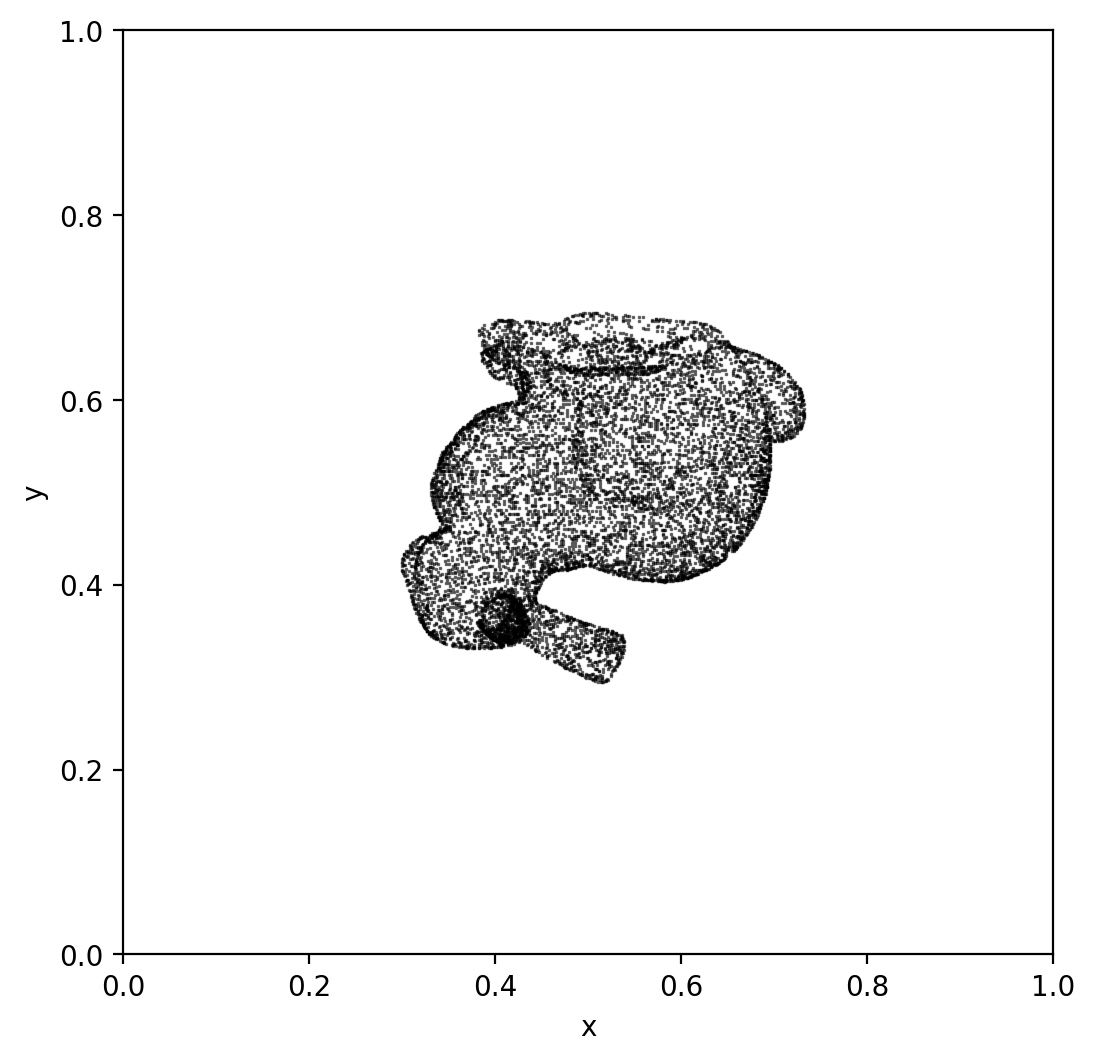

In [ ]:
v_hom = homogenize_points(verts)
xyz_cam_hom = transform_world2cam(v_hom, test_cam2world)
xy_pix_hom = project(xyz_cam_hom, test_K)

plot_image_space_points(xy_pix_hom[..., :2], xlim=(0, 1), ylim=(0, 1))

We note a few things:

1.   The bunny is on its head.
2.   This is a scatterplot of the continuous coordinates of projected points, whereas an image is usually discretized into a grid of pixels.
3.   Note that the origin $(0, 0)$ of this plot is at the bottom left! This is different from the OpenCV camera coordinate system that we assumed, where the origin is at the top left!

We have provided a function, `discretize_normalized_2d_pointclouid_to_img`, that addresses these points. You do not need to modify it, simply use it to display your point cloud scatterplot.

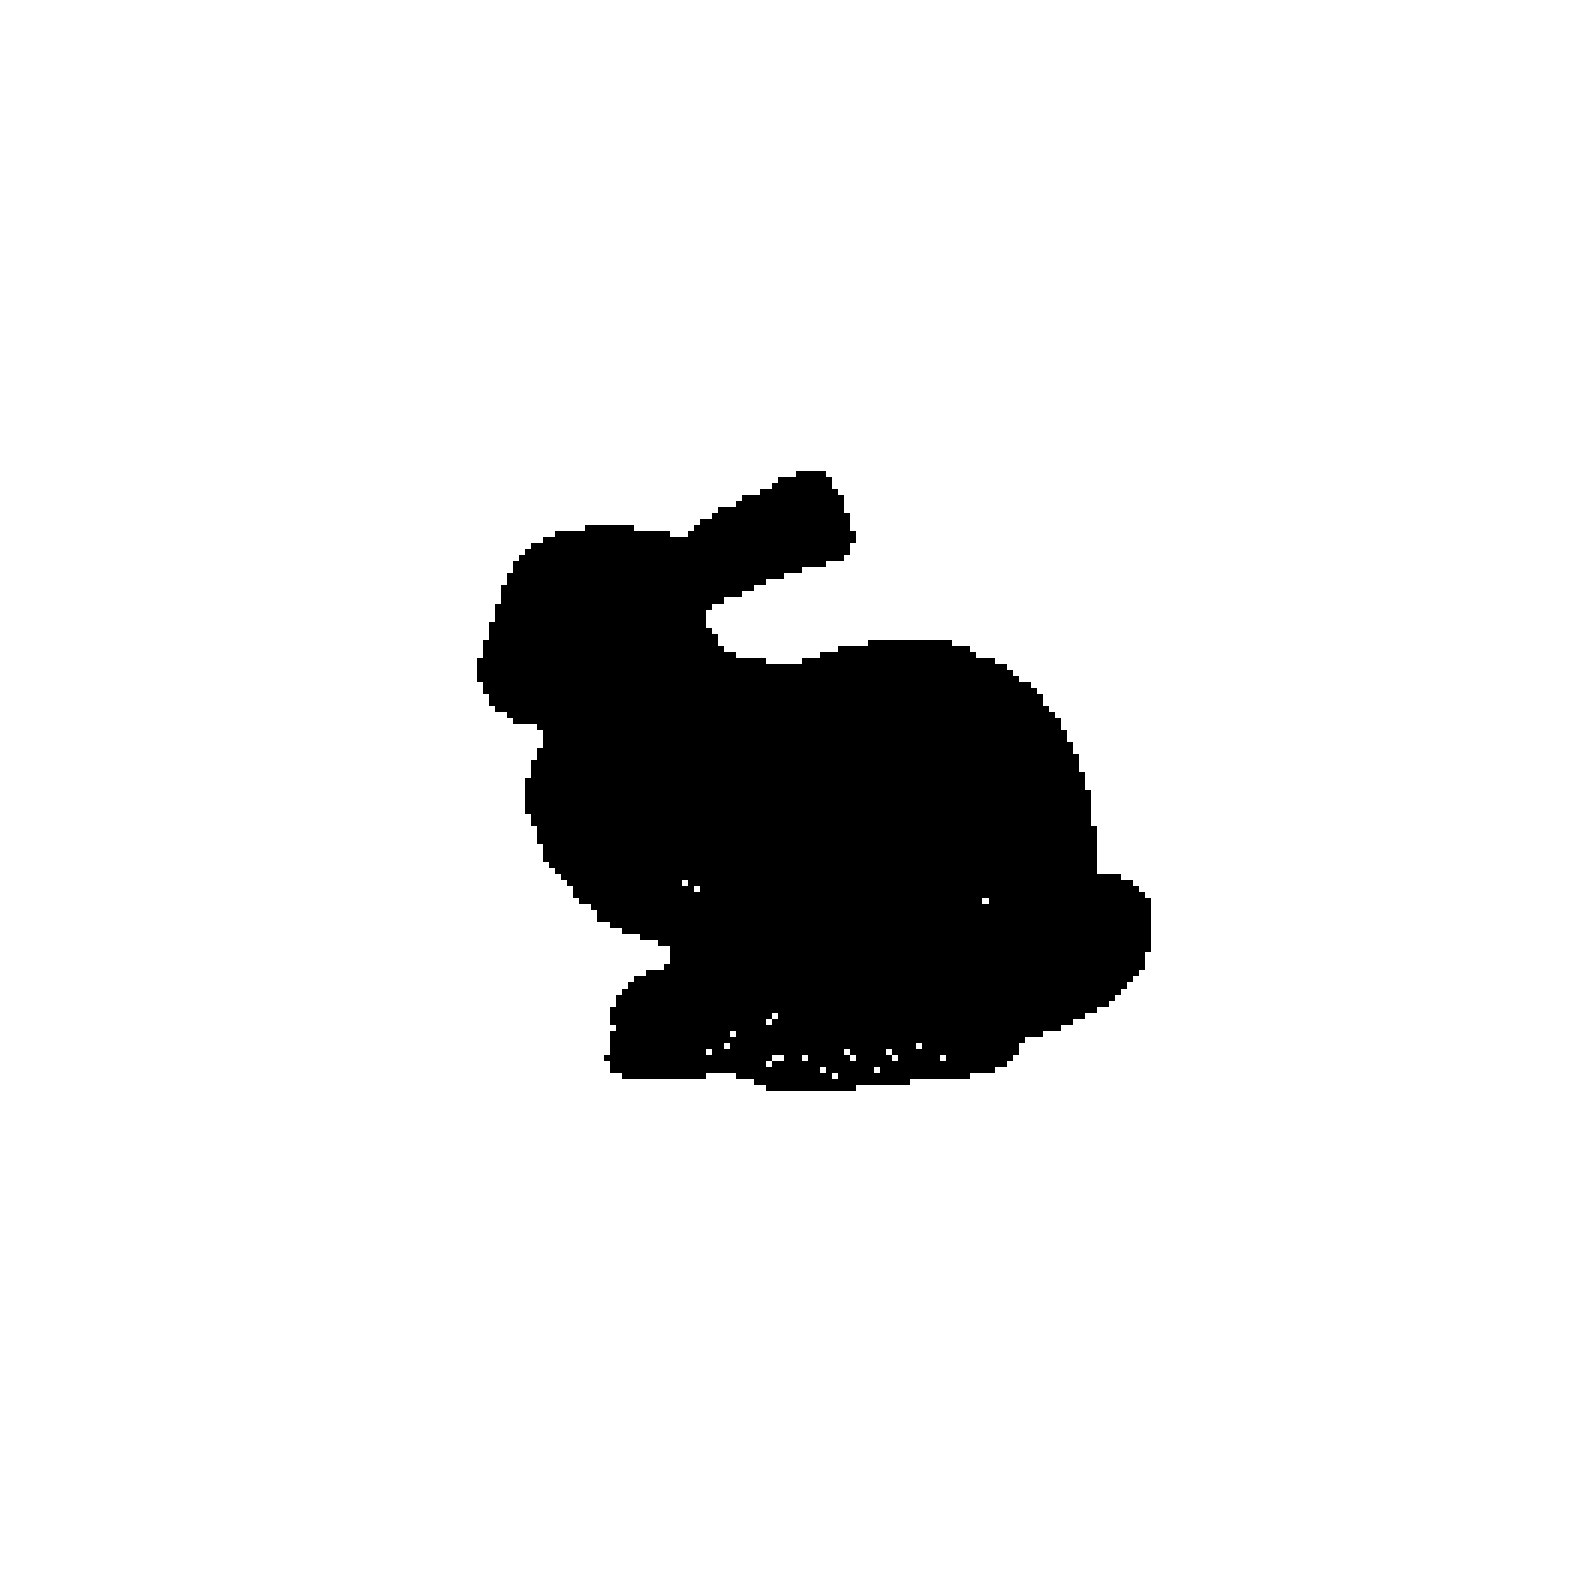

In [ ]:
def discretize_normalized_2d_pointcloud_to_img(
    pointcloud_2d,
    img_resolution = (100, 100)
):
    img = np.zeros(img_resolution)
    x, y = np.split(pointcloud_2d, 2, axis=-1)
    x *= img_resolution[0]
    y *= img_resolution[1]

    x, y = x.int(), y.int()
    img[y, x] = 1.

    return img

img = discretize_normalized_2d_pointcloud_to_img(xy_pix_hom.cpu()[..., :2],
                                          img_resolution=img_resolution)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='Greys')
plt.axis("off");
plt.show()

You should see an upright bunny silhouette. There may be a few empty pixels in the middle. This is normal since the vertices are not particularly dense.

To finish up Problem 1, let's put `transform_rigid()` to use and rotate the bunny.

Fill in `rotate_by_theta()` which rotates input 3D points about the **y-axis** in the clockwise direction (when viewed from above). You will have to come up with the appropriate rotation matrix and apply it using `transform_rigid()`. (See textbook [39.6](https://visionbook.mit.edu/imaging_geometry.html#a-few-concrete-examples) for some insights.)

In [ ]:
# @title 1 point
import math
def rotate_by_theta(xyz: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    """Rotate a (batch of) points around the origin.

    Args:
        xyz: 3D points of shape (N, 3)
        theta: scalar angle value in degrees. Shape: ()

    Returns:
        transformed points of shape (N, 3)
    """

    rad = theta * (math.pi / 180.0)
    c = torch.cos(rad)
    s = torch.sin(rad)

    # build zero/one scalars on the same device/dtype
    zero = torch.zeros_like(c)
    one  = torch.ones_like(c)

    # rows of R for clockwise about +Y:
    # [ cos, 0, -sin]
    # [   0, 1,    0]
    # [ sin, 0,  cos]
    row0 = torch.stack([   c, zero,  -s])
    row1 = torch.stack([ zero,   one, zero])
    row2 = torch.stack([   s, zero,   c])
    R = torch.stack([row0, row1, row2], dim=0)  # (3,3)

    # apply as row-vector: p' = p Rᵀ
    return xyz @ R.T

check_function(rotate_by_theta,
               [torch.tensor([[0., 0., 1]]), torch.tensor(90.)],
               [torch.tensor([[-1., 0., 0.]])])

We'll use the rotation method to animate a rotating bunny!
You don't have to modify `animate_bunny()`.

In [ ]:
def animate_bunny(verts, img_resolution=(100, 100)):
    frames = []
    for theta in range(0, 360, 10):
        rotated_verts = rotate_by_theta(verts, torch.tensor(theta))
        v_hom = homogenize_points(rotated_verts)
        xyz_cam_hom = transform_world2cam(v_hom, test_cam2world)
        xy_pix_hom = project(xyz_cam_hom, test_K)

        image = discretize_normalized_2d_pointcloud_to_img(
                    xy_pix_hom.cpu()[..., :2],
                    img_resolution=img_resolution)
        frames.append([image])

    return AnimationWrapper(rows=1, cols=1, frames=frames)

rotating_bunny_animation = animate_bunny(verts)
rotating_bunny_animation.generate()
rotating_bunny_animation.anim

Building animation... : 39it [00:08,  5.09it/s]

You should see a bunny silhouette rotating clockwise about the y-axis ('Up' direction)

If you do see this, your implementation of the transformation methods are likely correct! Proceed to the next problem.

# 2. Structured Light

We'll now apply these transformations to the problem of recovering depth using structured light. A real-world example of a structured light setup is the Kinect.

The Kinect consists of a camera and a projector, as shown in the figure below. The projector shines a structured pattern of light on the world (in the infrared spectrum so that it is invisible to our eyes).
The camera can see this pattern and observes how the light warps over the scene geometry.

The geometry of light rays emitted by the projector can be modeled similarly to a pinhole camera -- the projector has its own pose, intrinsics, image plane, etc.

![](https://drive.google.com/uc?id=1fA-L1Sf5QnCj9J0VJFcc4zbBxmjrL8v4)

## 2.1. Simulating a Light Projector


### Downloading the Motorcycle Scene

We'll download and process the motorcycle scene here. You do not have to modify this cell.

In [ ]:
# Before starting, run this cell to download the motorbike scene that we'll be using.
import scipy.io as sio
import requests
import cv2
import os

def download(url, fn):
    r = requests.get(url)
    if r.status_code == 200:
        open(fn, 'wb').write(r.content)
        print("{} downloaded: {:.2f} KB".format(fn, len(r.content)/1024.))
    else:
        print("url not found:", url)

os.makedirs('Motorcycle-perfect', exist_ok=True)
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/rgb_camera_view.png', 'Motorcycle-perfect/rgb_camera_view.png')
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/stripe_lights.png', 'Motorcycle-perfect/stripe_lights.png')
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/z_camera_view.mat', 'Motorcycle-perfect/z_camera_view.mat')
download('http://6.869.csail.mit.edu/sp22/pset2_data/Motorcycle-perfect/z_projector_view.mat', 'Motorcycle-perfect/z_projector_view.mat')

def make_motorcycle_scene(scale=0.2):

    f0 = 3979.911  # focal length in (pixels)
    d = 193.001  # baseline in (mm)
    cx_c, cy_c = (1244.772, 1019.507)  # principal point coordinates for the camera
    cx_p, cy_p = (1369.115, 1019.507)

    Z_p_img = sio.loadmat("./Motorcycle-perfect/z_projector_view.mat")["z_p_img"]
    Z_c_img = sio.loadmat("./Motorcycle-perfect/z_camera_view.mat")["z_c_img"]
    rgb_c_img = cv2.imread("./Motorcycle-perfect/rgb_camera_view.png")

    ksize = int(1.0 / scale) * 2 + 1
    Z_p_img = cv2.GaussianBlur(Z_p_img, (ksize, ksize), 0)
    Z_p_img = cv2.resize(Z_p_img, (0, 0), fx=scale, fy=scale)

    Z_c_img = cv2.GaussianBlur(Z_c_img, (ksize, ksize), 0)
    Z_c_img = cv2.resize(Z_c_img, (0, 0), fx=scale, fy=scale)

    rgb_c_img = cv2.GaussianBlur(rgb_c_img, (ksize, ksize), 0)
    rgb_c_img = cv2.resize(rgb_c_img, (0, 0), fx=scale, fy=scale)

    f = f0 * scale
    cx_c = cx_c * scale
    cy_c = cy_c * scale
    cx_p = cx_p * scale
    cy_p = cy_p * scale

    img_size = Z_p_img.shape

    proj_intrinsics = torch.tensor([[0.,  f,  cy_p],
                                    [f,  0.,  cx_p],
                                    [0., 0.,   1.]], device=device)

    cam_intrinsics = torch.tensor([[0.,  f,  cy_c],
                                  [f,  0.,  cx_c],
                                  [0., 0.,   1.]], device=device)

    proj_extrinsics = torch.tensor([[1.0,  0.,  0., 0.],
                                    [0.,  -1.,  0., 0.],
                                    [0.,   0., -1., 0.],
                                    [0.,   0.,  0., 1.]], device=device)

    cam_extrinsics = torch.tensor([[1.0,  0.,  0., -d],
                                  [0.,  -1.,  0., 0.],
                                  [0.,   0., -1., 0.],
                                  [0.,   0.,  0., 1.]], device=device)

    return Scene(rgb_ground_truth=torch.tensor(rgb_c_img),
                z_proj_ground_truth=torch.tensor(Z_p_img).float(),
                z_cam_ground_truth=torch.tensor(Z_c_img).float(),
                cam_extrinsics=cam_extrinsics.float(),
                cam_intrinsics=cam_intrinsics.float(),
                proj_extrinsics=proj_extrinsics.float(),
                proj_intrinsics=proj_intrinsics.float())

motorcycle_scene = make_motorcycle_scene(scale=0.04)
motorcycle_scene_large = make_motorcycle_scene(scale=0.2)


Motorcycle-perfect/rgb_camera_view.png downloaded: 7018.61 KB
Motorcycle-perfect/stripe_lights.png downloaded: 1.09 KB
Motorcycle-perfect/z_camera_view.mat downloaded: 39729.57 KB
Motorcycle-perfect/z_projector_view.mat downloaded: 39838.49 KB


We first try to simulate a laser projector which supplies illumination for a single projector pixel. i.e. for a given point on the projector's image space `uv_p`, find the corresponding point on the camera's image space that will be lit up.

We'll do this in these steps:


1.   'unproject' `uv_p` to get projector-space `xy_p` (3D point relative to projector's origin)
2.   Apply `cam2world()` using the _projector_'s extrinsic matrix to get `xy_w` (3D point relative to world's origin)
3.   Apply `world2cam()` using the _camera_'s extrinsic matrix to get `xy_c` (3D point relative to camera's origin)
4.   Use `project()` with _camera_'s intrinsic matrix to get `uv_c` (2D point on the camera's image-space)

We've already constructed `cam2world()`, `world2cam()` and `project()` in Problem 1.

The missing piece here is `unproject()`. You next task is to fill that in:


### 2.1. (a) The "unproject" Function

You'll now write a function ```unproject``` that takes x, y pixel coordinates and lifts them to 3D camera coordinates.

Recall the following equation for projecting a 3D coordinate in camera coordinates $\mathbf{X}$ to _homogeneous_ pixel coordinates:
$$
\begin{align}
    \begin{pmatrix}
    f \cdot X + Z \cdot p_x \\
    f \cdot Y + Z \cdot p_y\\
    Z
    \end{pmatrix} &= \mathbf{K} [\mathbf{I} | \mathbf{0} ]
    \begin{pmatrix}
    X \\
    Y \\
    Z \\
    1
    \end{pmatrix} \\
    \begin{pmatrix}
    f \cdot X + Z \cdot p_x \\
    f \cdot Y + Z \cdot p_y\\
    Z
    \end{pmatrix} &= \mathbf{K}
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix}
\end{align}
$$

Applying the inverse $\mathbf{K}^{-1}$ on both sides, we see:

$$
\begin{align}
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix} &= \mathbf{K}^{-1}
    \begin{pmatrix}
    f \cdot X + Z \cdot p_x \\
    f \cdot Y + Z \cdot p_y\\
    Z
    \end{pmatrix} \\
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix} &= Z \cdot \mathbf{K}^{-1}
    \begin{pmatrix}
    \frac{f \cdot X}{Z} + p_x \\
    \frac{f \cdot Y}{Z} + p_y\\
    1
    \end{pmatrix} \\
    \mathbf{X} &= Z \cdot \mathbf{K}^{-1}
    \begin{pmatrix}
    x_{pix} \\
    y_{pix} \\
    1
    \end{pmatrix}
\end{align}
$$

This relates 3D world coordinates along a ray to their pixel coordinates and the depth, and is exactly what you have to implement below.

In [ ]:
# @title 2 points
def unproject(
    uv_pix: torch.Tensor,
    z: torch.Tensor,
    intrinsics: torch.Tensor
    ) -> torch.Tensor:
    """Unproject (lift) pixel coordinates x_pix and per-pixel z coordinate
    to camera coordinates.

    Args:
        uv_pix: pixel coordinates of shape (N, 2)
        z: per-pixel depth, defined as z coordinate of shape (N,)
        intrinsics: camera intrinsics of shape (3, 3)

    Returns:
        points in 3D camera coordinates.
    """

    dtype, device = intrinsics.dtype, intrinsics.device
    uv = uv_pix.to(dtype=dtype, device=device)
    z  = z.to(dtype=dtype, device=device)

    # Build homogeneous pixel vectors (N,3)
    N = uv.shape[0]
    ones = torch.ones(N,1, dtype=dtype, device=device)
    uv1  = torch.cat([uv, ones], dim=1)            # (N,3)

    # Invert intrinsics once
    K_inv = torch.inverse(intrinsics)              # (3,3)

    # Normalize directions
    dirs = (K_inv @ uv1.T).T                       # (N,3)

    # Scale by depth
    return dirs * z.unsqueeze(1)

check_function(unproject,
                [torch.tensor([[0.0, 0.0]], device=device),
                 torch.tensor([5.0], device=device),
                 torch.tensor([[0.5, 0.0, 0.5],
                               [0.0, 0.5, 0.5],
                               [0.0, 0.0, 1.0]], device=device)],
                [torch.tensor([[-5.0000, -5.0000, 5.0000]]).to(device)])

### 2.1. (b) Simulating Structured Light
Now that we have all 4 pieces, let's write a function, `map_projector_coord_to_camera_coord`, that will take an projector's image space `uv_p` and map it to the camera's image space coordinate `uv_c`.

In [ ]:
# @title 3 points
def map_projector_coord_to_camera_coord(
    uv_p: torch.Tensor,
    z_p: torch.Tensor,
    proj_extrinsics: torch.Tensor,
    proj_intrinsics: torch.Tensor,
    cam_extrinsics: torch.Tensor,
    cam_intrinsics: torch.Tensor
  ) -> torch.Tensor:
    """Map the coordinate on the projector's image space to the
      camera's image space by following the 4 steps laid out in 2.1

     Args:
        uv_p: 2D pixel coordinates of shape (N, 2)
        z_p: corresponding pixel depths, defined as z coordinate of shape (N,)
        proj_extrinsics: projector's extrinsics of shape (4, 4)
        proj_intrinsics: projector's intrinsics of shape (3, 3)
        cam_extrinsics: camera's extrinsics of shape (4, 4)
        cam_intrinsics: camera's intrinsics of shape (3, 3)

     Returns: tuple(uv_c, z_c) where
        uv_c: 2D pixel coordinates of shape (N, 2)
        z_c: corresponding depths as seen by the camera (N,)
    """

    #
    # Try to follow these steps to complete this task:
    #
    # 1. Unproject projector's image space uv_p to get xy_p
    #    (3D coordinates relative to projector origin)
    #
    # 2. Transform xy_p to world coordinates (xy_w).
    #
    # 3. Transform xy_w to camera coordinates (xy_c).
    #    (3D cooridnates relative to camera origin)
    #
    # 4. Project onto camera's image space.
    #
    # (You may need to homogenize/dehomogenize your points before
    #  applying certain transforms)
    #

    # 1) lift into projector‐space
    xyz_p = unproject(uv_p, z_p, proj_intrinsics)       # (N,3)
    xyz_p_h = homogenize_points(xyz_p)                  # (N,4)

    # 2) → world
    xyz_w_h = transform_cam2world(xyz_p_h, proj_extrinsics)

    # 3) → camera coords
    xyz_c_h = transform_world2cam(xyz_w_h, cam_extrinsics)

    # de‐homogenize
    xyz_c = xyz_c_h[:, :3]                              # (N,3)
    z_c   = xyz_c[:, 2]                                 # (N,)

    # 4) → pixel
    uv_c_h = project(xyz_c_h, cam_intrinsics)           # (N,3)
    uv_c   = uv_c_h[:, :2]

    return uv_c, z_c

check_function(map_projector_coord_to_camera_coord,
              [torch.tensor([[1.0, 1.0]], device=device),

               torch.tensor([2.0], device=device),

               torch.tensor([[1., 0., 0., 0. ],
                             [0., -1., 0., 0.],
                             [0., 0., -1., 4.],
                             [0., 0., 0., 1. ]], device=device),

               torch.tensor([[0.5, 0.0, 0.5],
                             [0.0, 0.5, 0.5],
                             [0.0, 0.0, 1.0]], device=device),

               torch.tensor([[1., 0., 0.,  2.],
                             [0., -1., 0., 0.],
                             [0., 0., -1., 4.],
                             [0., 0., 0., 1.]], device=device),

               torch.tensor([[0.5, 0.0, 0.5],
                             [0.0, 0.5, 0.5],
                             [0.0, 0.0, 1.0]], device=device)],

              [torch.tensor([[0.5, 1.0]], device=device),

               torch.tensor([2.0], device=device)])

Next, we have provided a utility method `render_scene_with_projected_light()` which will use your `map_projector_coord_to_camera_coord()` method on each projector pixel coordinate `uv_p` to find the `uv_c` on the camera's image, and then accumulate the light values in that location.

Note that there can be multiple projector coordinates that map to the same camera coordinates (in this case, our utility method takes the depth into account to figure out which light value should used).

You do not need to modify this method.

In [ ]:
def render_scene_with_projected_light(
    light_image,
    z_proj,
    z_cam_gt,
    proj_extrinsics,
    proj_intrinsics,
    cam_extrinsics,
    cam_intrinsics):
    """
      light_image: per-pixel light intensity from the projector. Shape: (W, H)
      z_proj: per-pixel depths as seen from the projector. Shape: (W, H)
      proj_extrinsics: projector's extrinsics of shape (4, 4)
      proj_intrinsics: projector's intrinsics of shape (3, 3)
      cam_extrinsics: camera's extrinsics of shape (4, 4)
      cam_intrinsics: camera's intrinsics of shape (3, 3)

      Returns:
        image of the scene rendered with the provided structured light_image. Shape: (W, H)
    """
    assert (isinstance(light_image, torch.Tensor))

    W, H = light_image.shape

    # Make a set of inputs.
    (u_p, v_p) = torch.meshgrid(
                        torch.arange(0, W),
                        torch.arange(0, H),
                        indexing='ij')

    uv_p = torch.stack([u_p, v_p], axis=-1).reshape((-1, 2))
    z_proj = z_proj.flatten()

    light_vals = light_image.flatten()

    # To save on compute, only go through non-zero pixels in
    # the light image.
    #
    non_zero_indices = light_vals.nonzero()[:, 0]

    light_vals = light_vals[non_zero_indices]
    uv_p = uv_p[non_zero_indices, :]
    z_proj = z_proj[non_zero_indices]

    uv_c, z_cs = map_projector_coord_to_camera_coord(
        uv_p,
        z_proj,
        proj_extrinsics,
        proj_intrinsics,
        cam_extrinsics,
        cam_intrinsics)

    rendered_image = torch.zeros((W, H))
    num_samples = torch.zeros((W, H))

    log_progress = (light_vals.shape[0] > 500)
    pbar = tqdm.tqdm(
            total=light_vals.shape[0],
            position=0,
            leave=True,
            desc="Rendering projected light") if log_progress else None

    uv_c = uv_c.round().int()

    # Set depth error to 1% of mean absolute GT depth.
    abs_depth_buffer_error = 0.01 * (z_cam_gt).mean()

    for ((u_c, v_c), z_c, light_val) in zip(uv_c, z_cs, light_vals):
        pbar.update(1) if log_progress else None
        if W > u_c >= 0 and H > v_c >= 0 and abs(z_cam_gt[u_c, v_c] - z_c) < abs_depth_buffer_error:
          rendered_image[u_c, v_c] += light_val
          num_samples[u_c, v_c] += 1

    pbar.close() if log_progress else None

    rendered_image = rendered_image / num_samples
    rendered_image[rendered_image.isnan()] = 0.0

    return rendered_image


Now, let's see this in action, by shining a stripes pattern from our projector, and viewing our camera image on the side.

Rendering projected light: 100%|██████████| 69600/69600 [00:05<00:00, 11998.91it/s]


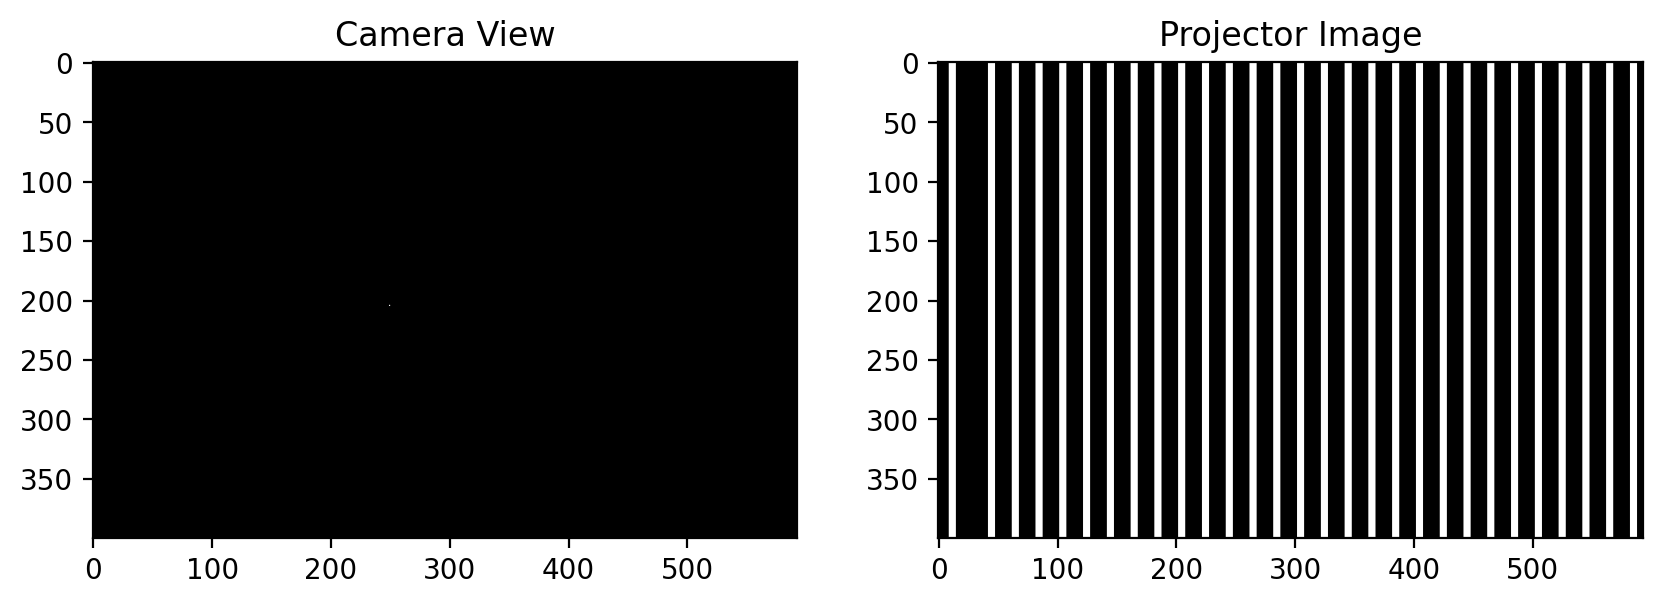

In [ ]:
# Load striped lights (single-channel)
stripe_lights_image = cv2.imread("./Motorcycle-perfect/stripe_lights.png")[:, :, 0]

W, H, C = motorcycle_scene_large.rgb_ground_truth.shape
stripe_lights_image = cv2.resize(stripe_lights_image, (H, W))

# Render scene with projected light
cam_image = render_scene_with_projected_light(
    torch.tensor(stripe_lights_image),
    motorcycle_scene_large.z_proj_ground_truth,
    motorcycle_scene_large.z_cam_ground_truth,
    motorcycle_scene_large.proj_extrinsics,
    motorcycle_scene_large.proj_intrinsics,
    motorcycle_scene_large.cam_extrinsics,
    motorcycle_scene_large.cam_intrinsics)

# Plot the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(cam_image.numpy(), cmap="gray")
ax1.set_title('Camera View')

ax2.imshow(stripe_lights_image, cmap="gray")
ax2.set_title('Projector Image')

plt.show()

You should see the straight stripes in the projector's image turn wiggly as they are projected onto the scene.

## 2.2 Depth from Single-Pixel Laser

Thus far we've been able to map projector coordinates to camera coordinates, *given the true depth* of the scene.

Since we know this mapping depends on the depth, what if we could come up with the *inverse* of this operation?
Can we infer the depth given a pair of matching coordinates? Yes! This is referred to as **triangulation**, and we will implement a simplified version of this.

We need two parts to accomplish this:
1. Given a matching pair of projector and camera coordinates `uv_p` and `uv_c`, infer the depth (`infer_depth_from_matched_coords()`)
2. A method to generate light patterns (`light_generator_fn()`) in such a way that we can _decode_ one or more pairs of matching coordinates from the camera's view of this projected pattern (`decoder_fn()`).


### 2.2 (a) Inferring Depth from Coordinate Pairs


Your task is to complete the method `infer_depth_from_matched_coords()`.

We will follow a process similar to the lecture, and take advantage of the properties of similar triangles. Here's a diagram of what this looks like:

![](https://drive.google.com/uc?id=1oQKFGak8iiEG0DlEuzKeHDBvJUovvLvy)

In [ ]:
# @title 3 points
def infer_depth_from_matched_coords(
    uv_c: torch.Tensor,
    uv_p: torch.Tensor,
    proj_extrinsics: torch.Tensor,
    proj_intrinsics: torch.Tensor,
    cam_extrinsics: torch.Tensor,
    cam_intrinsics: torch.Tensor
    ) -> torch.Tensor:
    """
      Args:
        uv_c: camera image positions in pixel coordinates of shape (N, 2)
        uv_p: projector image positions in pixel coordinates of shape (N, 2)
        proj_extrinsics: projector's extrinsic matrix of shape (4, 4)
        proj_intrinsics: projector's intrinsic matrix of shape (3, 3)
        cam_extrinsics: camera's extrinsic matrix of shape (4, 4)
        cam_intrinsics: camera's intrinsic matrix of shape (3, 3)

      Returns:
        z_c: inferred depths w.r.t the camera's origin (N,)
    """

    device, dtype = cam_intrinsics.device, cam_intrinsics.dtype

    # Baseline: ΔX = X_p - X_c
    O_p = proj_extrinsics[:3, 3]
    O_c = cam_extrinsics[:3, 3]
    B   = (O_p[0] - O_c[0]).to(dtype=dtype, device=device)

    # Focal length: off‐diagonal entry in your K (row=0,col=1)
    f = cam_intrinsics[0, 1]

    # disparity in the *v* coordinate (second component)
    disp = (uv_c[:, 1] - uv_p[:, 1]).to(dtype=dtype, device=device)

    return B * f / disp

check_function(infer_depth_from_matched_coords,
                [torch.tensor([[1.0, 1.0], [1.0, 0.6]], device=device),

                torch.tensor([[1.0, 0.5], [1.0, 0.5]], device=device),

                torch.tensor([[1., 0., 0.,  0. ],
                              [0., 1., 0., 0.],
                              [0., 0., 1., 4.],
                              [0., 0., 0.,  1. ]], device=device),

                torch.tensor([[0.0, 0.5, 0.5],
                              [0.5, 0.0, 0.5],
                              [0.0, 0.0, 1.0]], device=device),

                torch.tensor([[1., 0., 0.,  -2.],
                              [0., 1., 0., 0.],
                              [0., 0., 1., 4.],
                              [0., 0., 0., 1.]], device=device),

                torch.tensor([[0.0, 0.5, 0.5],
                              [0.5, 0.0, 0.5],
                              [0.0, 0.0, 1.0]], device=device)],

                [torch.tensor([2.0, 10.0], device=device)])

### Pattern Generator & Decoder Functions for a Laser
The last thing we need is a pair of methods: one that generates structured light patterns, and one that recovers pairs of matching coordinates given the image seen by the camera.

Remember that our goal is to generate light patterns in such a way that it is easy to recover corresponding pairs of coordinates.

For this example, we're going provide an implementation of the simplest answer to this: every projector image has a single pixel lit up (i.e. like a laser pointer). That way, there's at most one pixel illuminated in the camera's image, and there's no ambiguity.

We provide the implementations of the following functions for you. You do not have to modify these methods.

1.   `per_pixel_laser_light_fn()`: Generates a series of images for the projector with a single non-zero pixel each. We use python _generators_ for this. More info on generators [here](https://www.learnpython.org/en/Generators)

2.   `laser_decoder_fn()`: Generates two vectors of matched coordinates given the light image, and the corresponding simulated camera image. In the case of a single-pixel laser, we can only recover a single set of corresponding set of coordinates for each time we use the laser



In [ ]:
def per_pixel_laser_light(W, H):
    (u_ps, v_ps) = torch.meshgrid(
          torch.arange(0, W, step=1),
          torch.arange(0, H, step=1),
          indexing='xy')

    uv_p = torch.stack([u_ps, v_ps], axis=-1).reshape((-1, 2))

    for (u_p, v_p) in uv_p:
        light_image = torch.zeros((W, H))

        light_image[u_p, v_p] = 1

        yield (light_image, None)

def laser_decoder_fn(light_image, camera_image, extra_info=None):
  # Since we only expect a single pixel to be lit up, we'll
  # just use 'nonzero' to get the coordinates of that pixel.
  #
  uv_p = light_image.nonzero()
  uv_c = camera_image.nonzero()

  if (uv_c.shape[0] == 0):
    return None, None

  return uv_p, uv_c


### Putting these Together

Now we can put all these pieces together to recover a depth map!

We have provided a method `recover_depth_map()` that takes in a pair of structured light generator and decoder methods. You do not have to modify this.

Simply run the two cells below to see your results. If your implementation of
`infer_depth_from_matched_coordinates` is correct, you will see a good depth recovery animation.

In [ ]:
def recover_depth_map(
    W, H,
    structured_light_fn,
    decoder_fn,
    z_proj_gt,
    z_cam_gt,
    rgb_gt,
    proj_extrinsics,
    proj_intrinsics,
    cam_extrinsics,
    cam_intrinsics,
    plot_skip = 1
    ):

    camera_depth_image = torch.ones((W, H)) * torch.nan

    frames = []

    pbar = tqdm.tqdm(position=0, leave=True, desc="Recovering depth with light image")
    for index, (light_image, extra_info) in enumerate(structured_light_fn(W, H)):
        simulated_camera_image = render_scene_with_projected_light(
                                    light_image,
                                    z_proj_gt,
                                    z_cam_gt,
                                    proj_extrinsics,
                                    proj_intrinsics,
                                    cam_extrinsics,
                                    cam_intrinsics)

        uv_p, uv_c = decoder_fn(light_image, simulated_camera_image, extra_info)

        if (uv_c is None):
          continue

        z_cam = infer_depth_from_matched_coords(
                    uv_c,
                    uv_p,
                    proj_extrinsics,
                    proj_intrinsics,
                    cam_extrinsics,
                    cam_intrinsics)

        u_c, v_c = uv_c.permute((1, 0))
        camera_depth_image[u_c, v_c] = z_cam

        if (index % plot_skip == 0):
          pbar.update(plot_skip)
          frames.append([rgb_gt.numpy(), light_image.numpy(), simulated_camera_image.numpy(), camera_depth_image.clone().numpy()])

    depth_animation = AnimationWrapper(rows=2, cols=2, frames=frames)
    axes = depth_animation.get_axes()
    axes[0].set_title("Camera view with natural lighting")
    axes[1].set_title("Projector view of projected light")
    axes[2].set_title("Camera view of projected light")
    axes[3].set_title("Recovered depth map")

    return (camera_depth_image, depth_animation)

In [ ]:
W, H = motorcycle_scene.z_proj_ground_truth.shape

# Recover a depth map using the laser light generator and decoder method
z_recovered, depth_animation = recover_depth_map(
    W, H,
    per_pixel_laser_light,
    laser_decoder_fn,
    motorcycle_scene.z_proj_ground_truth,
    motorcycle_scene.z_cam_ground_truth,
    motorcycle_scene.rgb_ground_truth,
    motorcycle_scene.proj_extrinsics,
    motorcycle_scene.proj_intrinsics,
    motorcycle_scene.cam_extrinsics,
    motorcycle_scene.cam_intrinsics,
    plot_skip = 100)

# Display a progressive animation of the accumulated depth map
depth_animation.generate()
depth_animation.anim

Recovering depth with light image: 600it [00:09, 64.71it/s] 
Building animation... : 9it [00:01,  4.41it/s]

You should see an animation of the depth recovery as we go through the set of structured light images and add to the depth map.




## 2.3 Depth from Structured Light (optional)

The laser light approach is elegant. It is easy to decode the matching pairs.

However, you may have noticed that it is very *inefficient*. For a 1024x1024 image, you will have to produce over a **million** light images, making it  unviable in practice (unless you have a really high-power laser, but then you might set your scene on fire)

In practice we use patterns of light or a spatially-varying light signal to obtain more corresponding pairs per projected image.


### 2.3. (a) Efficient Generator & Decoder Functions

Your next (and final) task is to come up with a more efficient pair of methods.

Fill in `my_structured_light_generator_fn()` and `my_decoder_fn()`. Remember that you can call `render_scene_with_projected_light()` to see what your lighting pattern looks like when applied to the scene.



In [ ]:
# @title 0 points
def my_structured_light_generator_fn(W: int, H: int) -> Iterable[Tuple[torch.Tensor, Optional[Any]]]:
    """
      Args:
        W: width of the projector image in pixels
        H: height of the projector image in pixels

      Yields, 1 or more times, a tuple of:
        light_image: image to be projected of shape (W, H)
        extra_info: optional extra info to be passed onto the decoder fn.
                    Use 'None' if you don't need this output.
    """

    # Notes:
    #
    # This function should be a python 'generator'. Instead of using
    # 'return', use 'yield' to return one or more images.
    # This feature is handy since you can use a single pattern if you want, or an
    # arbitrary number of different patterns (just remember to write your decoder
    # accordingly).
    # Alternatively, you can simply return a list of images (but generators are
    # more memory-efficient)
    #
    # For our simple simulation setup, we have 'perfect' reflectance.
    # That is, we recover the exact light value that we project, only the
    # position on the image plane changes. This lets us recover depth using a
    # single light image, i.e. using a single yield statement and without using
    # the 'extra_info' argument.
    #
    # Hint: project a signal that is a function of uv_p, so that you can decode
    # uv_p just by looking at the signal value at each uv_c.
    #
    # Alternatively, you can also use the provided stripes pattern, and 'scan' it
    # horizontally while applying edge-detection to decode matching pairs.
    # This approach is closer to what is used in real-world scenarios since we
    # cannot assume a perfect reflectance model.
    #

    raise NotImplementedError


def my_decoder_fn(
    light_image: torch.Tensor,
    camera_image: torch.Tensor,
    extra_info: Any = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
      Args:
        light_image: projector's light image generated from the generator_fn
        camera_image: camera image of the projected light
        extra_info: optional extra information from the generator fn (See above)

      Returns (a tuple of):
        uv_p: list of pixel coordinates on the projector's image space with shape (N, 2)
        uv_c: corresponding list of pixel coordinates on the camera's image space with shape (N, 2)

      Note: N can be whatever number of pairs you are able to decode from a
            single pair of structured light image and corresponding camera image.
            The higher N is, the more efficient your structured light pattern.
            You should recover at least 80% of pixels on this scene for full
            credit (use the function below to verify this).
            You might not need to use light_image or extra_info.
    """

    raise NotImplementedError

In [ ]:
# verifies your generator and decoder functions behave correctly
def check_generator_decoder_fns(
      generator_fn,
      decoder_fn,
      scene,
      max_relative_L1_error,
      max_light_image_count,
      min_recovered_fraction):

    W, H = scene.z_cam_ground_truth.shape

    n_light_images = len([image for image in generator_fn(W, H)])
    recovered_depth, _ = recover_depth_map(
                W, H,
                generator_fn,
                decoder_fn,
                scene.z_proj_ground_truth,
                scene.z_cam_ground_truth,
                scene.rgb_ground_truth,
                scene.proj_extrinsics,
                scene.proj_intrinsics,
                scene.cam_extrinsics,
                scene.cam_intrinsics,
                plot_skip = 1)
    print("")

    non_nan_mask = ~recovered_depth.isnan()
    relative_L1_error = (abs(recovered_depth[non_nan_mask] - scene.z_cam_ground_truth[non_nan_mask])
                            / torch.max(scene.z_cam_ground_truth)).mean()
    recovered_fraction = recovered_depth[non_nan_mask].numel() / scene.z_cam_ground_truth.numel()

    correct = True
    if relative_L1_error > max_relative_L1_error:
        print("\033[31m ", f'Expected relative L1 error below {max_relative_L1_error:.5f}. Got: {relative_L1_error:.5f}.', " \033[0m")
        correct = False

    if n_light_images > max_light_image_count:
        print("\033[31m ", f'Expected fewer than {max_light_image_count} projector images. Got: {n_light_images}.', " \033[0m")
        correct = False

    if recovered_fraction < min_recovered_fraction:
        print("\033[31m ", f'Expected atleast {(min_recovered_fraction * 100):.2f}% of depth image to be recovered. Got: {(recovered_fraction * 100):.2f}%.', " \033[0m")
        correct = False

    if correct:
        print("\033[32m ", f'{generator_fn.__name__}/{decoder_fn.__name__}: Your generator-decoder pair works!', " \033[0m")
    else:
        print("\033[31m ", f'{generator_fn.__name__}/{decoder_fn.__name__}: Your generator-decoder does NOT work!', " \033[0m")

from math import sqrt

# Together, the two functions are worth 5 points.
check_generator_decoder_fns(
    my_structured_light_generator_fn,
    my_decoder_fn,
    motorcycle_scene_large,
    max_relative_L1_error=0.02,
    max_light_image_count=(4 * sqrt(motorcycle_scene_large.z_cam_ground_truth.numel())),
    min_recovered_fraction=0.8)

Once you have an implementation, run the next cell to recover depth again, but with your new structured light method.

In [ ]:
W, H = motorcycle_scene_large.rgb_ground_truth.shape[:-1]

# Recover a depth map using your structured light.
# Together, the two functions are worth 5 points.
z_recovered, depth_animation = recover_depth_map(
    W, H,
    my_structured_light_generator_fn,
    my_decoder_fn,
    motorcycle_scene_large.z_proj_ground_truth,
    motorcycle_scene_large.z_cam_ground_truth,
    motorcycle_scene_large.rgb_ground_truth,
    motorcycle_scene_large.proj_extrinsics,
    motorcycle_scene_large.proj_intrinsics,
    motorcycle_scene_large.cam_extrinsics,
    motorcycle_scene_large.cam_intrinsics,
    plot_skip = 1)

# Display a progressive animation of the accumulated depth map
depth_animation.generate()
depth_animation.anim

You should be able to see a recovered depth map, as well a print statements showing how many light images you had to use.



# 3. Optical Flow

Here we will apply the Lucas and Kanade gradient-based optical flow algorithm to videos. See [textbook chapter 48](https://visionbook.mit.edu/optical_flow.html#gradient-based-optical-flow-estimation) for a review on optical flow.

We will use a simple example by simulating 2 moving blocks.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, convolve1d

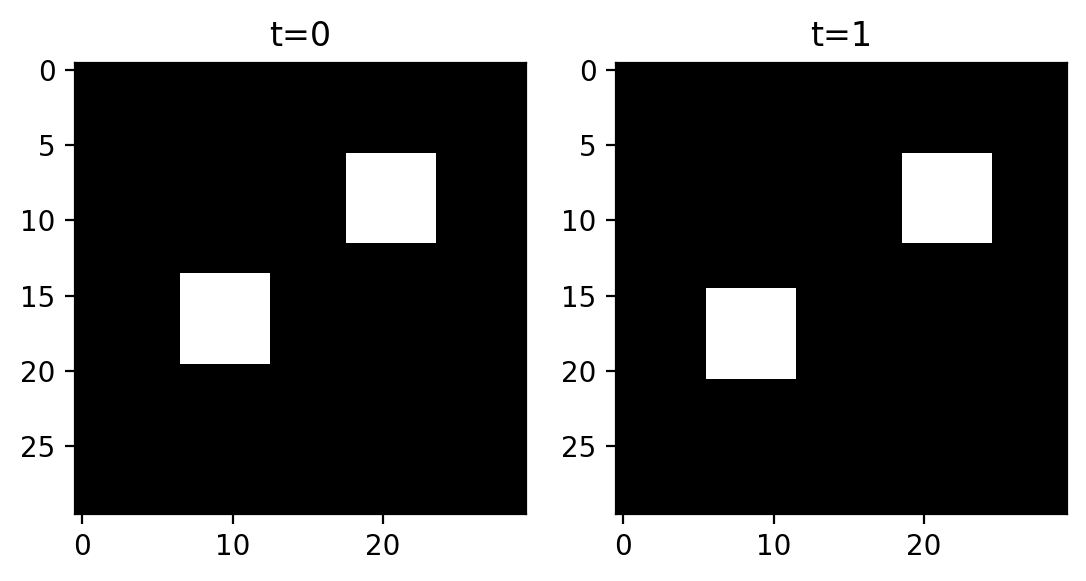

In [ ]:
# Initialize simple 2-frame video

vid = np.zeros([2, 30, 30])

# First frame (t = 0)
vid[0, 14:20, 7:13] = 1
vid[0, 6:12, 18:24] = 1

# Second frame (t = 1)
vid[1, 15:21, 6:12] = 1
vid[1, 6:12, 19:25] = 1

plt.figure()
plt.subplot(121)
plt.title('t=0')
plt.imshow(vid[0], cmap='gray')
plt.subplot(122)
plt.title('t=1')
plt.imshow(vid[1], cmap='gray')
plt.show()

## 3.1 Gradient-Based Optical Flow
To apply the gradient-based optical flow algorithm, follow the pseudo-code from [48.1](https://visionbook.mit.edu/optical_flow.html#alg-gradient_algorithm) by completing the steps:
1. Blur the input frames with a 5x5 Gaussian.
2. Extract first order derivatives (*lx, ly, lt*).
3. Compute blurred second order derivatives (*lx2, lxly, ly2, lxlt, lylt*), which will be used to build **A** and **b** matrices.
4. Iterate through each pixel of the frame to solve for $[u, v]$, the flow in the x and y directions, by building **A** and **b** for each pixel:

   $$
   A = \left[
   \begin{array}{cc}
   \sum g \ell_x^2 & \sum g \ell_x \ell_y \\
   \sum g \ell_x \ell_y & \sum g \ell_y^2
   \end{array}
   \right]
   $$

   $$
   b = - \begin{bmatrix}
   \sum g \ell_x \ell_t \\
   \sum g \ell_y \ell_t
   \end{bmatrix}
   $$

   and solving the inverse equation:

   $$
   \begin{bmatrix}
   u \\
   v
   \end{bmatrix}
   =
   A^{-1} \cdot b
   $$

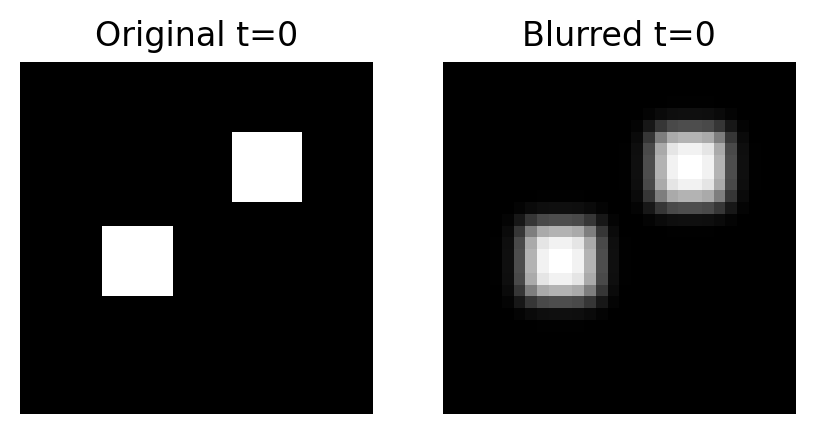

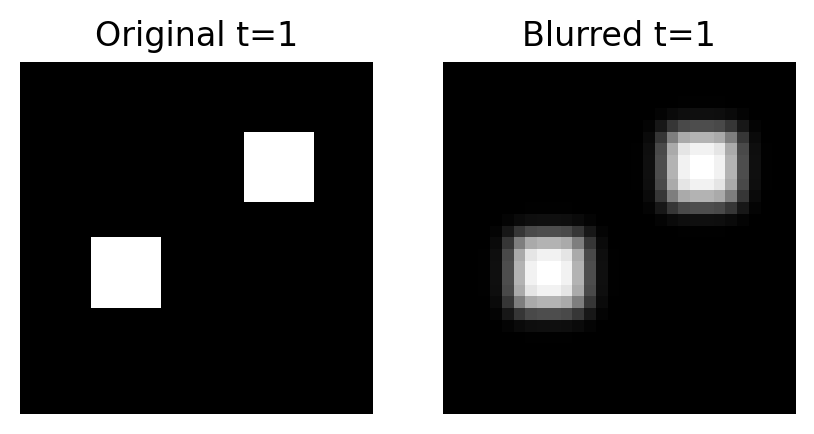

In [ ]:
# 1. TODO: Blur each frame with 5x5 gaussian with sigma=1
from scipy.ndimage import gaussian_filter
vid_blurred = np.stack([gaussian_filter(frame, sigma=1) for frame in vid], axis=0)

#######################################

# Visualize the blurred frames
plt.figure(figsize=(5,5))
plt.subplot(121)
plt.title('Original t=0')
plt.imshow(vid[0], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title('Blurred t=0')
plt.imshow(vid_blurred[0], cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.subplot(121)
plt.title('Original t=1')
plt.imshow(vid[1], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title('Blurred t=1')
plt.imshow(vid_blurred[1], cmap='gray')
plt.axis('off')
plt.show()

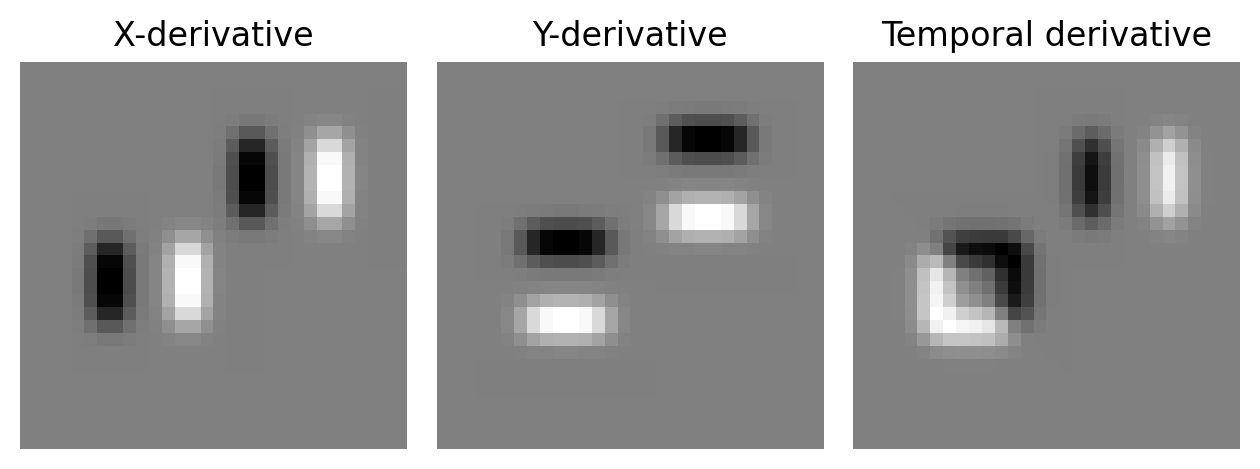

In [ ]:
# 2. TODO: Extract spatial and temporal derivatives
# For the spatial derivatives we use the kernel [1,-8,0,8,-1]/12 for the x-derivative and its transposed for the y-derivative.
# The temporal derivative can be computed as the difference of two consecutive blurred frames.
k = np.array([1, -8, 0, 8, -1], float) / 12
lx = convolve(vid_blurred[0], k[np.newaxis, :], mode='reflect')
ly = convolve(vid_blurred[0], k[:, np.newaxis], mode='reflect')
lt = vid_blurred[1] - vid_blurred[0]

#######################################
# Visualize the first derivatives

plt.subplot(1, 3, 1)
plt.title("X-derivative")
plt.imshow(lx, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Y-derivative")
plt.imshow(ly, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Temporal derivative")
plt.imshow(lt, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 3. TODO: Compute second order derivatives lx2, lxly, ly2, lxlt, and lylt. Remember to blur with G.




from scipy.ndimage import gaussian_filter

lx2  = gaussian_filter(Ix * Ix, sigma=1)
lxly = gaussian_filter(Ix * Iy, sigma=1)
ly2  = gaussian_filter(Iy * Iy, sigma=1)
lxlt = gaussian_filter(Ix * It, sigma=1)
lylt = gaussian_filter(Iy * It, sigma=1)

#######################################
# Visualize the second derivatives

plt.figure(figsize=(10,5))

plt.subplot(1, 5, 1)
plt.title("lx^2")
plt.imshow(lx2, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title("lxly")
plt.imshow(lxly, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title("ly^2")
plt.imshow(ly2, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.title("lxlt")
plt.imshow(lxlt, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title("lylt")
plt.imshow(lylt, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'Ix' is not defined

In [ ]:
# 4. TODO: Solve optical flow equation. Build matrix A and b at each pixel, then solve for flow using [u,v] = inv(A)@b

# Create matrix A and b with second derivatives

# Initialize output flow fields
H, W = lx.shape
u = np.zeros((H, W))
v = np.zeros((H, W))

# Fill in flow

for i in range(H):
    for j in range(W):
        A = np.array([[lx2[i,j], lxy[i,j]],
                      [lxy[i,j], ly2[i,j]]])
        b = np.array([-lxt[i,j], -lyt[i,j]])
        # only solve if A is well-conditioned
        if np.linalg.cond(A) < 1e3:
            uv = np.linalg.solve(A, b)
            u[i,j], v[i,j] = uv
        else:
            u[i,j], v[i,j] = 0.0, 0.0

In [ ]:
# Plot flow
def plot_flow(u, v):
  step = 1
  H, W = u.shape
  y, x = np.mgrid[0:H:step, 0:W:step]

  # Plot flow using quiver
  plt.figure(figsize=(8, 8))
  plt.quiver(x, y, u[::step, ::step], v[::step, ::step],
            color='black', scale=None, scale_units='xy', angles='xy')
  plt.gca().invert_yaxis()
  plt.axis('equal')
  plt.axis('off')
  plt.show()

plot_flow(u, v)

## 3.2 Iterative Refinement

Here, we will implement iterative refinement for optical flow computation (see [textbook chapter 48.3](https://visionbook.mit.edu/optical_flow.html#gradient-based-optical-flow-estimation) ). Adding iterations will provide a more accurate estimate of optical flow. At each iteration , the estimated optical flow will be used to compute the warped frame and we will compute an update, $\Delta u_n$ and $\Delta v_n$, of the optical flow: $u_{n + 1} = u_n + \Delta u_n$ and $v_{n + 1} = v_n + \Delta v_n$. To improve the results, the optical flow estimation is done on a Gaussian pyramid. First, we run a few iterations on the lowest resolution scale of the pyramid (where the motion will be the smallest). The estimated motion is then upsampled and used as initialization at the next level. We iterate this process until arriving at the highest possible resolution.

Copy your code from 3.1 into the first method below. Fill in the other TODO. The warping and the multiscale refinement is done for you.

In [ ]:
import cv2
def compute_flow(img1, img2):
  # 1. TODO: Blur each frame with 5x5 gaussian with sigma=1
  f1 = gaussian_filter(img1, sigma=1)
  f2 = gaussian_filter(img2, sigma=1)

  # 2. TODO: Extract spatial and temporal derivatives
  k = np.array([1, -8, 0, 8, -1], dtype=float) / 12.0
  Ix = convolve(f1, k[np.newaxis, :], mode='reflect')
  Iy = convolve(f1, k[:, np.newaxis], mode='reflect')
  It = f2 - f1

  # 3. TODO: Compute second order derivatives lx2, lxly, ly2, lxlt, and lylt. Remember to blur with G.
  Ix2  = gaussian_filter(Ix * Ix, sigma=1)
  Iy2  = gaussian_filter(Iy * Iy, sigma=1)
  Ixy  = gaussian_filter(Ix * Iy, sigma=1)
  Ixt  = gaussian_filter(Ix * It, sigma=1)
  Iyt  = gaussian_filter(Iy * It, sigma=1)

  # 4. TODO: Solve optical flow equation. Build matrix A and b at each pixel, then solve for flow using [u,v] = inv(A)@b
  denom = (Ix2 * Iy2 - Ixy * Ixy) + 1e-6
  u = (-Iy2*Ixt + Ixy*Iyt) / denom
  v = ( Ixy*Ixt - Ix2*Iyt) / denom

  return u,v

def warp_image(img, u, v):
    """
    Warp image using backward warping given optical flow (u, v).

    Parameters:
        img (H x W x C) or (H x W): input image
        u (H x W): optical flow in x-direction
        v (H x W): optical flow in y-direction

    Returns:
        Warped image of same shape as input
    """
    H, W = u.shape
    # Create mesh grid of pixel coordinates
    x, y = np.meshgrid(np.arange(W), np.arange(H))

    # Backward warping: destination <- source
    map_x = (x - u).astype(np.float32)
    map_y = (y - v).astype(np.float32)

    # Use OpenCV remap for backward warping
    if img.ndim == 2:  # grayscale
        warped = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    else:  # color
        warped = np.zeros_like(img)
        for c in range(img.shape[2]):
            warped[..., c] = cv2.remap(img[..., c], map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    return warped

def iterative_refinement(niters, img1, img2, u=None, v=None):

  if u is None:
    u = np.zeros_like(img1)
  if v is None:
    v = np.zeros_like(img1)


  for _ in range(niters):
    warped2 = warp_image(img2, u, v)
    du, dv = compute_flow(img1, warped2)
    u += du
    v += dv
    # TODO
    pass

  return u, v

def multiscale_iterative_refinement(niters, img1, img2, num_scales=4, pyr_scale=0.5):
    """
    Perform coarse-to-fine optical flow estimation using Gaussian pyramid.

    Parameters:
        niters: int — number of iterations at each scale
        img1, img2: ndarray — input grayscale images
        num_scales: int — number of pyramid levels
        pyr_scale: float — scale factor between levels (e.g., 0.5 = half size)

    Returns:
        u, v: final flow fields at full resolution
    """

    # Ensure float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Build Gaussian pyramids
    pyramid1 = [img1]
    pyramid2 = [img2]
    for _ in range(1, num_scales):
        img1 = cv2.pyrDown(pyramid1[-1])
        img2 = cv2.pyrDown(pyramid2[-1])
        pyramid1.append(img1)
        pyramid2.append(img2)

    # Start from coarsest scale
    u, v = np.zeros_like(pyramid1[-1]), np.zeros_like(pyramid1[-1])

    for level in reversed(range(num_scales)):
        img1_lvl = pyramid1[level]
        img2_lvl = pyramid2[level]

        # Upsample flow to current level
        if level < num_scales - 1:
            u = cv2.resize(u, (img1_lvl.shape[1], img1_lvl.shape[0])) * (1 / pyr_scale)
            v = cv2.resize(v, (img1_lvl.shape[1], img1_lvl.shape[0])) * (1 / pyr_scale)

        # Refine flow at this level
        u, v = iterative_refinement(niters, img1_lvl, img2_lvl, u, v)

    return u, v



In [ ]:
plot_flow(*multiscale_iterative_refinement(3, vid[0], vid[1], num_scales=3, pyr_scale=0.5))

## 3.3 Motion Magnification with Optical Flow

We can use the optical flow estimation to magnify motion. We will try this on the same video from pset 2. Fill in the TODO below.

In [ ]:
! curl http://6.869.csail.mit.edu/sp21/pset3_data/bill.avi > bill.avi
cap = cv2.VideoCapture('bill.avi')
fps = int(cap.get(cv2.CAP_PROP_FPS))

# list of video frames
frames = []

while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()

    if ret is False:
        break
    frame = cv2.resize(frame, (424, 240))
    frame = frame[:, 80:80+240]
    frames.append(frame)

cap.release()

# scale frame to 0-1
frames = np.array(frames)
print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

# get height, width
numFrames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

In [ ]:
from tqdm import tqdm
def magnify_motion(video_frames, flow_func, magnification_factor=2):
    """
    Compute optical flow between frames and magnify motion.

    Parameters:
        video_frames: list or array of frames (each H x W x C or H x W)
        flow_func: function that computes (u, v) given (img1, img2)
        magnification_factor: amount by which to amplify motion

    Returns:
        magnified_frames: list of warped frames with amplified motion
    """
    magnified_frames = [video_frames[0]]  # First frame stays the same

    for i in tqdm(range(1, len(video_frames))):
        prev = video_frames[i - 1].astype(np.float32)
        curr = video_frames[i].astype(np.float32)

        # If color, convert to grayscale for flow estimation
        if prev.ndim == 3:
            prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
            curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
        else:
            prev_gray = prev
            curr_gray = curr

        # TODO
        u, v = flow_func(prev_gray, curr_gray)
        # Compute flow from previous to current frame

        # Magnify the flow
        u *= magnification_factor
        v *= magnification_factor

        # Warp previous frame using magnified flow
        warped = warp_image(prev, u, v)
        magnified_frames.append(warped.clip(0,255).astype(np.uint8))

    return magnified_frames

In [ ]:
### Note:
### The output video will likely flicker and show severe magnification artifacts

# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('bill_magnification.avi', fourcc, 30.0, (height, width))
flow = lambda im1, im2: multiscale_iterative_refinement(3, im1, im2, num_scales=3, pyr_scale=0.5)
magnified_frames = magnify_motion(frames, flow, magnification_factor=2)
for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = np.clip(magnified_frames[i], 0, 255).astype(np.uint8)
    # write frame to output video
    out.write(frame)

out.release()

In [ ]:
# Only for colab downloading videos
try:
    from google.colab import files
    files.download('bill_magnification.avi')
except:
    print("Only for google colab")

# Submission Instructions

Be sure you have tested your code, and have not changed any function names. A minimal check that your code runs without error is to click "Runtime -> Restart session and run all". We will only consider regrade requests under exceptional circumstances.

Use "File -> Download -> Download `.ipynb`" and upload the file to Gradescope. **Do not submit a report or anything else**: the autograder will give you 0 if you submit anything other than a .ipynb file.